In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

train_df = pd.read_csv('/kaggle/input/tmdb-box-office-prediction/train.csv')
test_df = pd.read_csv('/kaggle/input/tmdb-box-office-prediction/test.csv')

/kaggle/input/tmdb-box-office-prediction/sample_submission.csv
/kaggle/input/tmdb-box-office-prediction/train.csv
/kaggle/input/tmdb-box-office-prediction/test.csv


# Klargjøring av data / Feature engineering

In [2]:
def data_labeling(df):

    #Transformerer data til tall.
    df['homepage'] = df['homepage'].notna()
    df['belongs_to_collection'] = df['belongs_to_collection'].notna()
    df['tagline'] = df['tagline'].notna()
    df['Keywords'] = df['Keywords'].fillna('[]')
    df['Keywords'] = df['Keywords'].apply(len)
    
    import ast
    df['crew'] = df['crew'].fillna('[]')
    df['crew'] = df['crew'].apply(ast.literal_eval)
    df['cast'] = df['cast'].fillna('[]')
    df['cast'] = df['cast'].apply(ast.literal_eval)
    df['employees'] = df['crew'].apply(len) + df['cast'].apply(len)
    
    df['release_date'] = df['release_date'].fillna('1/1/00')
    df['year'] = pd.to_datetime(df['release_date'], format='%m/%d/%y').dt.year
    df['year'] = np.where(df['year'] > 2020, df['year'] - 100, df['year'])
    df['month'] = pd.to_datetime(df['release_date'], format='%m/%d/%y').dt.month
    df['day'] = pd.to_datetime(df['release_date'], format='%m/%d/%y').dt.dayofweek
    
    df['production_id'] = df['production_companies'].apply(lambda x: x[0]['id'] if isinstance(x, list) and len(x) > 0 else None)
    df['english'] = df['original_language'] == 'en'
    
    
    #One-hot-encoding    
    def one_hot_encoding(df, feature, key):
        
        # Convert string representation of list of dictionaries to actual list of dictionaries
        df[feature] = df[feature].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) else [])

        # Getting unique genre names
        unique_genres = set()
        for index, row in df.iterrows():
            for genre in row[feature]:
                unique_genres.add(genre[key])

        # Create a dictionary to store one-hot-encoded values
        encoded_genres = {}
        for genre in unique_genres:
            encoded_genres[genre] = df[feature].apply(lambda x: int(any(g[key] == genre for g in x)))

        # Concatenate the one-hot-encoded columns to the DataFrame
        df = pd.concat([df] + [pd.Series(encoded_genres[genre], name=genre) for genre in unique_genres], axis=1)

        # Dropping the original 'genres' column
        df.drop(feature, axis=1, inplace=True)
        
        return df
        
    df = one_hot_encoding(df, 'genres', 'name')
    
    
    # Boolske verdier settes til 1/0
    boolean_columns = df.select_dtypes(include='bool').columns
    df[boolean_columns] = df[boolean_columns].astype(int)
    
    
    # Dropper features
    df.drop(['id', 'original_title', 'title', 'poster_path', 'overview', 'status'], axis=1, inplace=True)
    df = df.select_dtypes(include=[np.number]) # Fjerner features som ikke er tall.
    true_counts = df.sum() # Fjerner features med få verdier.
    df.drop(columns=true_counts[true_counts < 50].index, inplace=True)
    
    
    # Flytter revenue til siste kolonne
    if 'revenue' in df.columns:
        column = df.pop('revenue')
        df['revenue'] = column
    
    
    return df


train_df = data_labeling(train_df)

# Visualisering av data

In [3]:
train_df.head()

,belongs_to_collection,budget,homepage,popularity,runtime,tagline,Keywords,employees,year,month,...,Comedy,War,Romance,Thriller,Science Fiction,Drama,Documentary,Music,History,revenue
0,1,14000000,0,6.575393,93.0,1,151,96,2015,2,...,1,0,0,0,0,0,0,0,0,12314651
1,1,40000000,0,8.248895,113.0,1,142,29,2004,8,...,1,0,1,0,0,1,0,0,0,95149435
2,0,3300000,1,64.299990,105.0,1,448,115,2014,10,...,0,0,0,0,0,1,0,0,0,13092000
3,0,1200000,1,3.174936,122.0,0,258,10,2012,3,...,0,0,0,1,0,1,0,0,0,16000000
4,0,0,0,1.148070,118.0,0,2,6,2009,2,...,0,0,0,1,0,0,0,0,0,3923970


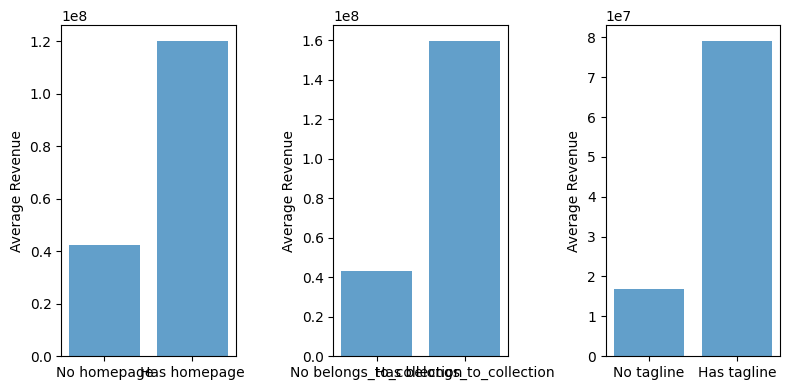

In [4]:
import matplotlib.pyplot as plt

# Assuming train_df is your DataFrame containing these columns

cols_to_plot = ['homepage', 'belongs_to_collection', 'tagline', 'revenue']
train_plot_df = train_df[cols_to_plot]

# Convert categorical columns to numerical for plotting
train_plot_df = train_plot_df.applymap(lambda x: 0 if pd.isnull(x) else 1)

fig, axs = plt.subplots(1, 3, figsize=(8, 4))

# Reshape the axs object to flatten it
axs = axs.ravel()

for i, col in enumerate(train_plot_df.columns[:-1]):
    avg_revenue = train_df.groupby(col)['revenue'].mean()
    labels = ['No ' + col, 'Has ' + col]
    x = range(len(labels))

    axs[i].bar(x, avg_revenue, alpha=0.7)
    axs[i].set_ylabel('Average Revenue')
    axs[i].set_xticks(x)
    axs[i].set_xticklabels(labels)

plt.tight_layout()
plt.show()

* Filmer uten metadata har typisk lavere omsetning.

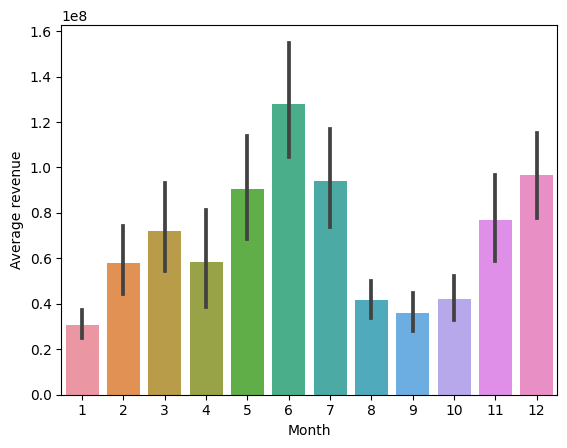

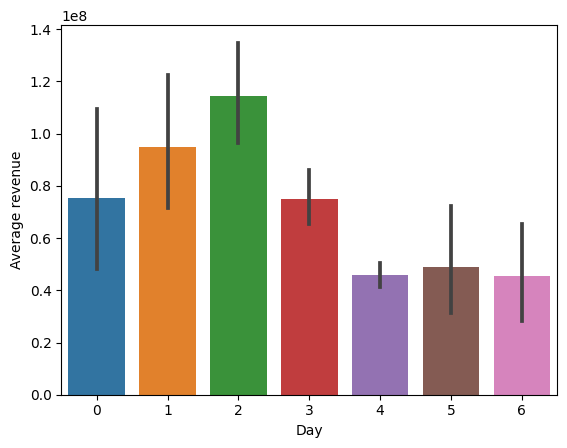

In [5]:
import seaborn as sns
sns.barplot(x=train_df['month'], y=train_df['revenue'])

plt.xlabel('Month')
plt.ylabel('Average revenue')

plt.show()

sns.barplot(x=train_df['day'], y=train_df['revenue'])

plt.xlabel('Day')
plt.ylabel('Average revenue')

plt.show()

* Både enkelte måneder og dager er forbundet med høyere innteker, kanskje det er knyttet til lanseringer av storproduksjoner?

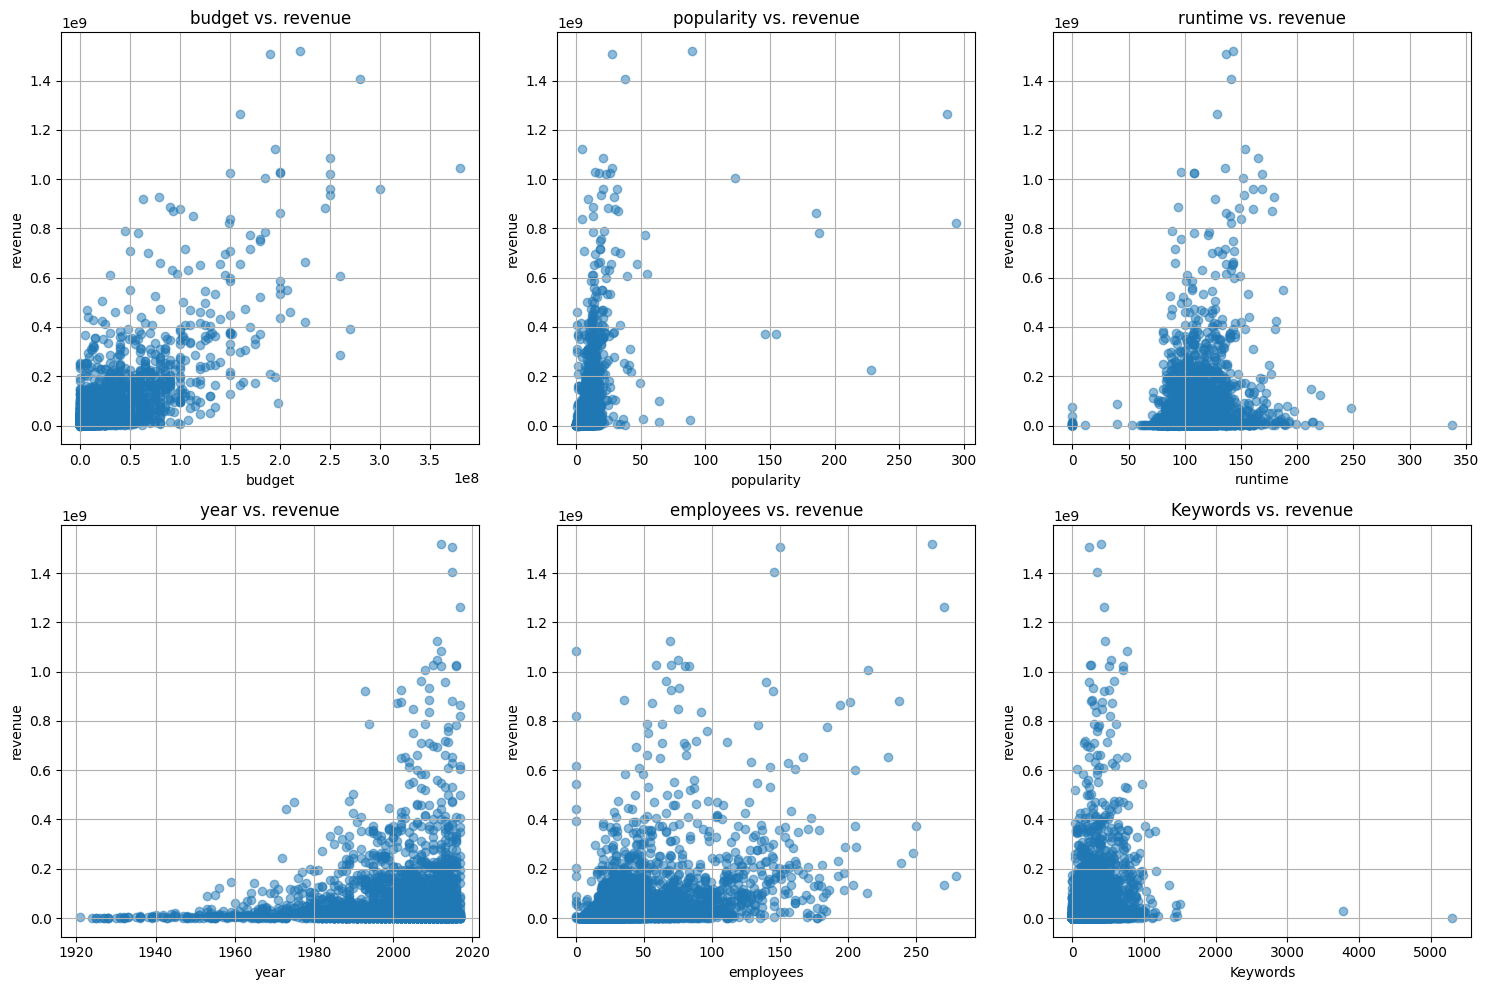

In [6]:
import matplotlib.pyplot as plt

# List of columns to create scatter plots for
columns_to_plot = ['budget', 'popularity', 'runtime', 'year', 'employees', 'Keywords']

# Calculate the number of rows and columns for the subplots
num_columns = 3
num_rows = (len(columns_to_plot) + num_columns - 1) // num_columns

# Create subplots
fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 10))

# Flatten the axes array for easier iteration
axes = axes.ravel()

# Create scatter plots for each column against 'revenue'
for i, column in enumerate(columns_to_plot):
    axes[i].scatter(train_df[column], train_df['revenue'], alpha=0.5)
    axes[i].set_title(f'{column} vs. revenue')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('revenue')
    axes[i].grid(True)

# Remove any empty subplots if the number of plots is not a multiple of 3
for i in range(len(columns_to_plot), num_rows * num_columns):
    fig.delaxes(axes[i])

# Show the plot
plt.tight_layout()
plt.show()

* Budsjett er tilknyttet omsetning.
* Popularitet er tilknyttet omsetning.
* Filmer som ikke har ideel runtime har lav omsetning.
* Omsetningen har steget med årene.
* Antall skuespillere/produksjon er tilknyttet omsetning.


# Preprossesering av data

In [7]:
from scipy.stats.mstats import winsorize

preprocess = [
    'employees', 'Keywords'
]

def preprocess_dataframe(df):
    
    # Begrenser ekstremverdier 
    for column in preprocess:
        df.loc[:, column] = winsorize(df[column], limits=[0, 0.001])
    
    # Setter manglende data til gjennomsnitt
    df = df.fillna(df.mean())
    
    return df

train_df = preprocess_dataframe(train_df)

# Modeller

In [8]:
from sklearn.model_selection import train_test_split
training_df, validate_df = train_test_split(train_df, test_size=0.3, random_state=12)
X_train, y_train = training_df.to_numpy()[:, :-1], training_df.to_numpy()[:, -1]

from sklearn.ensemble import RandomForestRegressor
model_rf = RandomForestRegressor(n_estimators=200, random_state=42).fit(X_train, y_train)

from catboost import CatBoostRegressor
model_cb = CatBoostRegressor(iterations=1600, verbose=1000).fit(X_train, y_train)

import xgboost as xgb
model_xgb = xgb.XGBRegressor(n_estimators=600, learning_rate=0.1, max_depth=5).fit(X_train, y_train)

Learning rate set to 0.031415
0:	learn: 136024780.1677109	total: 56.8ms	remaining: 1m 30s
1000:	learn: 29330627.3319433	total: 2.05s	remaining: 1.23s
1599:	learn: 21287627.6253378	total: 3.25s	remaining: 0us


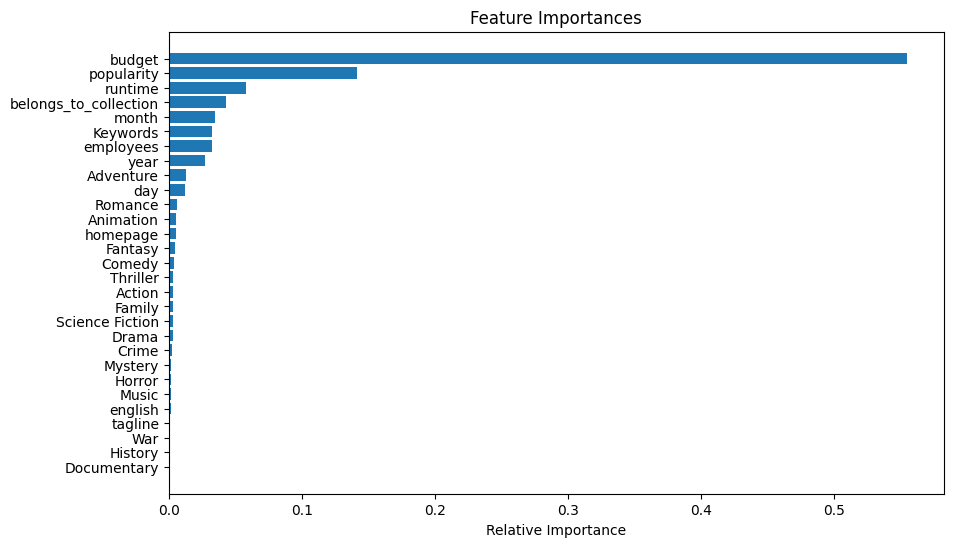

In [9]:
# Extract feature importances
importances = model_rf.feature_importances_

# Sort feature importances in descending order
indices = importances.argsort()[::-1]

# Reverse indices to display most important features at the top
indices = indices[::-1]

# Rearrange feature names based on the sorted feature importances
names = training_df.columns[:-1][indices]  # Assuming the last column is the target variable

# Plot feature importances with most important at the top
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.barh(range(training_df.shape[1] - 1), importances[indices], align='center')
plt.yticks(range(training_df.shape[1] - 1), names)
plt.xlabel('Relative Importance')
plt.show()

# Modelltesting

0.7626539427525598
0.7350060680545889
0.7139544243981706


/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


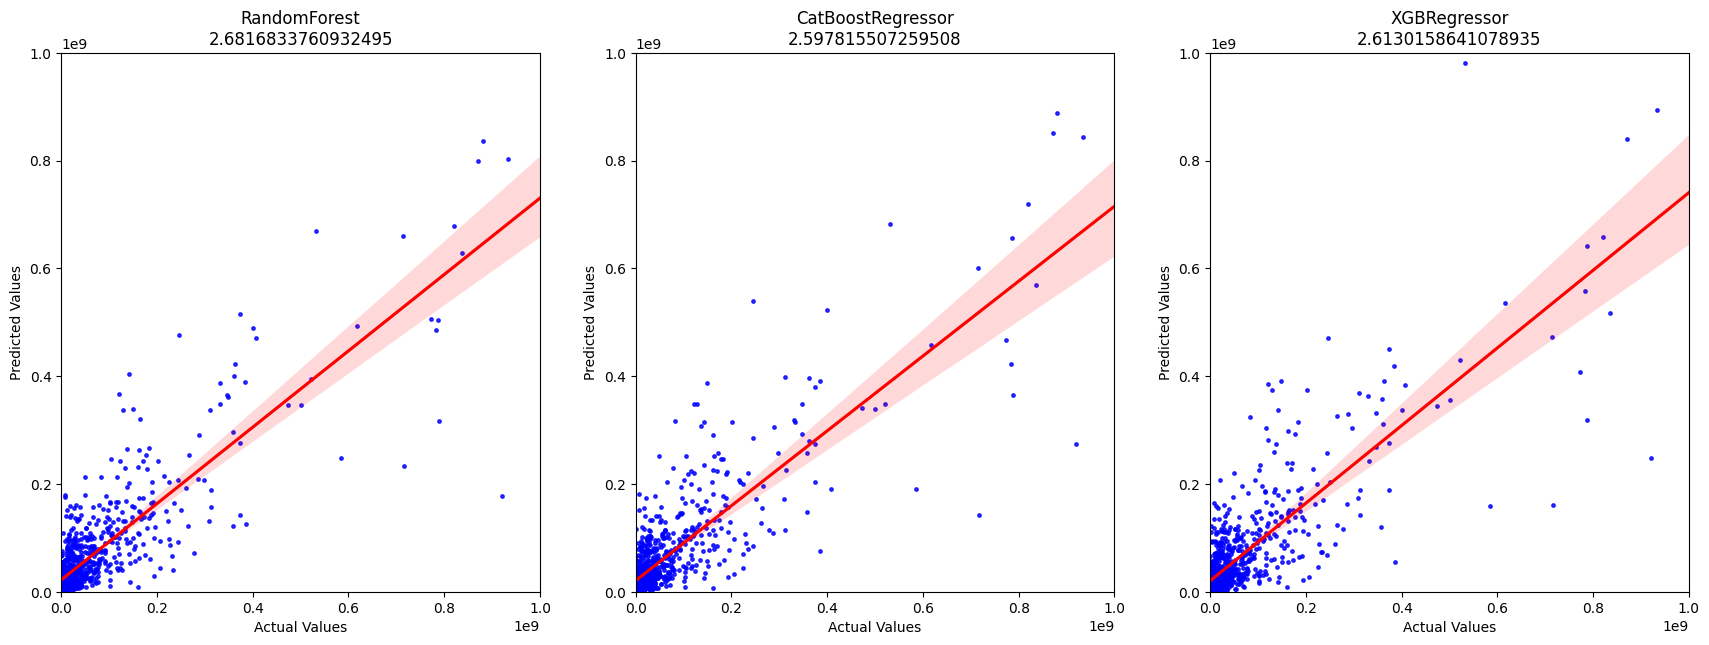

In [10]:
X_test = validate_df.to_numpy()[:, :-1]
validate_df['prediction'] = model_rf.predict(X_test)
validate_df['prediction_cb'] = model_cb.predict(X_test)
validate_df['prediction_xgb'] = model_xgb.predict(X_test)

from sklearn.metrics import r2_score
print(r2_score(validate_df['revenue'], validate_df['prediction']))
print(r2_score(validate_df['revenue'], validate_df['prediction_cb']))
print(r2_score(validate_df['revenue'], validate_df['prediction_xgb']))


# Create a figure with three subplots side by side
fig, axs = plt.subplots(1, 3, figsize=(21, 7))

# First plot
target = validate_df['revenue']
pred_lr = validate_df['prediction']
sns.regplot(x=target, y=pred_lr, scatter_kws={'color': 'blue', 's': 6}, line_kws={'color': 'red'}, ax=axs[0])
axs[0].set_xlabel('Actual Values')
axs[0].set_ylabel('Predicted Values')
axs[0].set_title('RandomForest\n' + str(np.sqrt(np.mean((np.log1p(validate_df['prediction']) - np.log1p(validate_df['revenue']))**2))))
axs[0].set_xlim(0, 1e9)  # Set x-axis limit for comparison
axs[0].set_ylim(0, 1e9)  # Set y-axis limit for comparison

# Second plot
target2 = validate_df['revenue']  # Replace with your second DataFrame
pred_lr2 = validate_df['prediction_cb']  # Replace with your second DataFrame
sns.regplot(x=target2, y=pred_lr2, scatter_kws={'color': 'blue', 's': 6}, line_kws={'color': 'red'}, ax=axs[1])
axs[1].set_xlabel('Actual Values')
axs[1].set_ylabel('Predicted Values')
axs[1].set_title('CatBoostRegressor\n' + str(np.sqrt(np.mean((np.log1p(validate_df['prediction_cb']) - np.log1p(validate_df['revenue']))**2))))
axs[1].set_xlim(0, 1e9)  # Set x-axis limit for comparison
axs[1].set_ylim(0, 1e9)  # Set y-axis limit for comparison

# Third plot
target3 = validate_df['revenue']  # Replace with your third DataFrame
pred_lr3 = validate_df['prediction_xgb']  # Replace with your third DataFrame
sns.regplot(x=target3, y=pred_lr3, scatter_kws={'color': 'blue', 's': 6}, line_kws={'color': 'red'}, ax=axs[2])
axs[2].set_xlabel('Actual Values')
axs[2].set_ylabel('Predicted Values')
axs[2].set_title('XGBRegressor\n' + str(np.sqrt(np.mean((np.log1p(validate_df['prediction_xgb']) - np.log1p(validate_df['revenue']))**2))))
axs[2].set_xlim(0, 1e9)  # Set x-axis limit for comparison
axs[2].set_ylim(0, 1e9)  # Set y-axis limit for comparison

# Show the plot
plt.show()

# Klargjøring testdata

In [11]:
# Trener modell på all data.
X_train, y_train = train_df.to_numpy()[:, :-1], train_df.to_numpy()[:, -1]
model = RandomForestRegressor(n_estimators=200, random_state=42).fit(X_train, y_train)

# Behandler
test_df_sub = data_labeling(test_df)
test_df_sub = preprocess_dataframe(test_df_sub)

columns_to_drop = [col for col in test_df_sub.columns if col not in train_df.columns]
test_df_sub.drop(columns=columns_to_drop, inplace=True)

missing_columns = [col for col in train_df.columns if col not in test_df_sub.columns]
test_df_sub = test_df_sub.reindex(columns=list(test_df_sub.columns) + missing_columns, fill_value=0)
test_df_sub.drop(['revenue'], axis=1, inplace=True)

# Estimerer
X_test = test_df_sub.to_numpy()[:, :]
test_df['revenue'] = model.predict(X_test)

# Testfil
submission = test_df[['id', 'revenue']]
submission.to_csv('submission.csv', index=False)